In [1]:
# 1.2 Installation Verification
import sys
print(f"Python version: {sys.version}") 

try:
    import chonkie
    print(f"Chonkie version: {chonkie.__version__}")
except ImportError:
    print("ERROR: Chonkie not installed. Please run: pip install -r requirements.txt")
    
# Import required libraries
from dotenv import load_dotenv
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import List, Dict

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\nAll required libraries loaded successfully!")

Python version: 3.12.10 (main, Apr  9 2025, 04:06:22) [MSC v.1943 64 bit (AMD64)]
Chonkie version: 1.5.0

All required libraries loaded successfully!


In [2]:
# 1.3 Load Environment Variables
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if not GOOGLE_API_KEY or GOOGLE_API_KEY == "your_api_key_here":
    print("WARNING: Gemini API key not configured!")
    print("Please set your GEMINI_API_KEY in the .env file")
    print("Get your key from: https://makersuite.google.com/app/apikey")
else:
    print("Gemini API key loaded successfully!")

Gemini API key loaded successfully!


In [3]:
# 1.4 Setup Google Gemini Embeddings
from chonkie import GeminiEmbeddings

# Initialize Gemini embeddings
try:
    embeddings = GeminiEmbeddings(
        model="gemini-embedding-001",
        api_key=GOOGLE_API_KEY,
        task_type="SEMANTIC_SIMILARITY"
    )
    
    # Test embeddings
    test_text = "Hello, this is a test embedding"
    test_vector = embeddings.embed(test_text)
    
    print(f"Embedding dimension: {len(test_vector)}")
    print(f"Sample values: {test_vector[:5]}")
    print("\nGemini embeddings configured successfully!")
except Exception as e:
    print(f"Error setting up Gemini embeddings: {e}")
    print("Continuing with tutorial - semantic chunkers will not work without valid API key")

c:\Users\shara\OneDrive\Documents\Live Courses Krish Naik\R_A_G\LLamaIndex\.llama\Lib\site-packages\chonkie\embeddings\gemini.py:78: UserWarning: Model gemini-embedding-001 not in known models list. Using default model 'gemini-embedding-exp-03-07' with dimension 3072 and max tokens 8192.
  warnings.warn(


Embedding dimension: 3072
Sample values: [-0.03420706  0.01485292 -0.00731989 -0.0750412  -0.01339855]

Gemini embeddings configured successfully!


In [4]:
# 1.5 Load Sample Data
# Load technical documentation
with open("new_data/sample_technical_doc.txt", "r") as f:
    technical_doc_text = f.read()

# Load research paper
with open("new_data/sample_research_paper.txt", "r") as f:
    research_paper_text = f.read()

# Load code sample
with open("new_data/sample_code.py", "r") as f:
    code_text = f.read()

# Load table sample
with open("new_data/sample_table.md", "r") as f:
    table_text = f.read()

print(f"Technical Doc: {len(technical_doc_text):,} characters")
print(f"Research Paper: {len(research_paper_text):,} characters")
print(f"Code Sample: {len(code_text):,} characters")
print(f"Table Sample: {len(table_text):,} characters")

# Display sample
print("\n--- Technical Doc Preview ---")
print(technical_doc_text[:300] + "...")

Technical Doc: 7,473 characters
Research Paper: 14,482 characters
Code Sample: 12,943 characters
Table Sample: 6,159 characters

--- Technical Doc Preview ---
# Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite of chunking algorithms designed for different document types and use cases.

## Installation

### Bas...


In [5]:
# 1.6 Helper Functions

def display_chunks(chunks, max_display=3, show_metadata=True):
    """Display chunks with metadata."""
    print(f"\nTotal chunks: {len(chunks)}")
    print("="*80)
    
    for i, chunk in enumerate(chunks[:max_display]):
        print(f"\nChunk {i+1}:")
        print(f"Text: {chunk.text[:200]}...")
        if show_metadata and hasattr(chunk, 'token_count'):
            print(f"Token count: {chunk.token_count}")
        if show_metadata and hasattr(chunk, 'start_char'):
            print(f"Position: {chunk.start_char} - {chunk.end_char}")
        print("-" * 80)
    
    if len(chunks) > max_display:
        print(f"\n... and {len(chunks) - max_display} more chunks")


def visualize_chunk_sizes(chunks, title="Chunk Size Distribution"):
    """Create bar chart of chunk token counts."""
    token_counts = [chunk.token_count if hasattr(chunk, 'token_count') else len(chunk.text) for chunk in chunks]
    
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(token_counts, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.title(f'{title}\nDistribution')
    plt.axvline(np.mean(token_counts), color='red', linestyle='--', label=f'Mean: {np.mean(token_counts):.0f}')
    plt.legend()
    
    # Box plot
    plt.subplot(1, 2, 2)
    plt.boxplot(token_counts, vert=True)
    plt.ylabel('Token Count')
    plt.title(f'{title}\nBox Plot')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nStatistics:")
    print(f"  Mean: {np.mean(token_counts):.1f}")
    print(f"  Median: {np.median(token_counts):.1f}")
    print(f"  Std Dev: {np.std(token_counts):.1f}")
    print(f"  Min: {min(token_counts)}")
    print(f"  Max: {max(token_counts)}")


def compare_chunkers(text, chunkers_dict, sample_size=1000):
    """Compare multiple chunkers on same text."""
    results = {}
    sample_text = text[:sample_size] if len(text) > sample_size else text
    
    for name, chunker in chunkers_dict.items():
        start_time = time.time()
        chunks = chunker.chunk(sample_text)
        elapsed = time.time() - start_time
        
        token_counts = [chunk.token_count if hasattr(chunk, 'token_count') else len(chunk.text) 
                       for chunk in chunks]
        
        results[name] = {
            'num_chunks': len(chunks),
            'avg_size': np.mean(token_counts),
            'std_dev': np.std(token_counts),
            'time': elapsed
        }
    
    df = pd.DataFrame(results).T
    return df

print("Helper functions loaded!")

Helper functions loaded!



Total chunks: 6

Chunk 1:
Text: # Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite o...
Token count: 512
--------------------------------------------------------------------------------

Chunk 2:
Text: "]
batch_chunks = chunker.chunk_batch(texts)
```

### TokenChunker API

The TokenChunker splits text into fixed-size token chunks with configurable overlap.

**Parameters:**
- `tokenizer` (Tokenizer):...
Token count: 512
--------------------------------------------------------------------------------

Chunk 3:
Text:  limits.

**Parameters:**
- `tokenizer` (Tokenizer): Tokenizer instance
- `chunk_size` (int): Maximum tokens per chunk (default: 512)
- `min_sentences_per_chunk` (int): Minimum sentences per chunk (de...
Token count: 512
--------------------------------------------------------------------------------

... and 3 more chunks


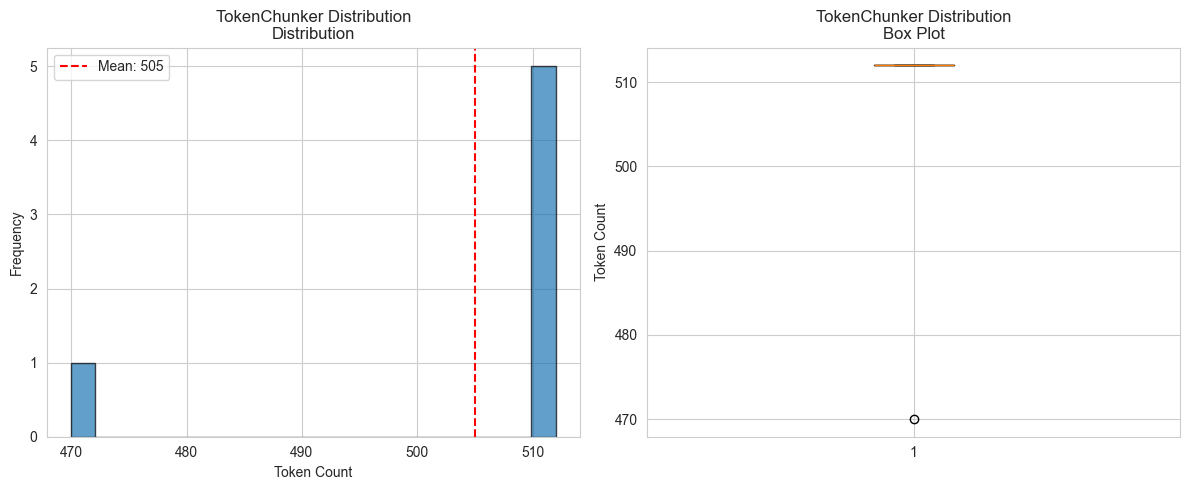


Statistics:
  Mean: 505.0
  Median: 512.0
  Std Dev: 15.7
  Min: 470
  Max: 512


In [6]:
from chonkie import TokenChunker
from tokenizers import Tokenizer

# Initialize tokenizer
tokenizer = Tokenizer.from_pretrained("gpt2")

# Create TokenChunker
token_chunker = TokenChunker(
    tokenizer=tokenizer,
    chunk_size=512,      # Max tokens per chunk
    chunk_overlap=128    # Overlapping tokens between chunks
)

# Chunk technical documentation
token_chunks = token_chunker.chunk(technical_doc_text)

# Display results
display_chunks(token_chunks)
visualize_chunk_sizes(token_chunks, "TokenChunker Distribution")

In [7]:
token_chunker_small = TokenChunker(tokenizer=tokenizer, chunk_size=256, chunk_overlap=64)
small_chunks = token_chunker_small.chunk(technical_doc_text[:2000])
display_chunks(small_chunks)


Total chunks: 3

Chunk 1:
Text: # Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite o...
Token count: 256
--------------------------------------------------------------------------------

Chunk 2:
Text: ):

```bash
pip install chonkie[semantic]
```

**All Features:**
Install everything, including code chunking and LLM-powered chunking:

```bash
pip install chonkie[all]
```

## Quick Start

### Basic ...
Token count: 256
--------------------------------------------------------------------------------

Chunk 3:
Text: "]
batch_chunks = chunker.chunk_batch(texts)
```

### TokenChunker API

The TokenChunker splits text into fixed-size token chunks with configurable overlap.

**Parameters:**
- `tokenizer` (Tokenizer):...
Token count: 228
--------------------------------------------------------------------------------



Total chunks: 6

Chunk 1:
Text: Semantic Chunking Strategies for Retrieval-Augmented Generation Systems

Abstract

Retrieval-Augmented Generation (RAG) systems have emerged as a powerful paradigm for enhancing large language models ...
Token count: 472
--------------------------------------------------------------------------------

Chunk 2:
Text: Neural approaches employ fine-tuned models to detect discourse-level shifts, while late chunking techniques defer segmentation until after contextualized embedding generation.

This paper makes the fo...
Token count: 489
--------------------------------------------------------------------------------

Chunk 3:
Text: Hierarchical chunking maintains multiple granularities simultaneously. However, these approaches have not been systematically compared across diverse document types and retrieval scenarios.

3. Method...
Token count: 479
--------------------------------------------------------------------------------

... and 3 more chunks


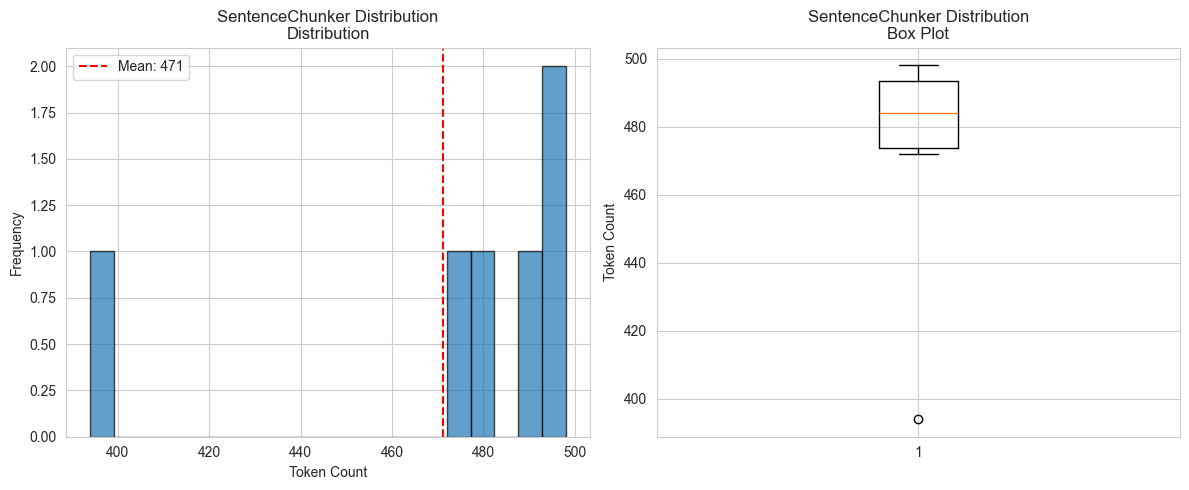


Statistics:
  Mean: 471.2
  Median: 484.0
  Std Dev: 35.6
  Min: 394
  Max: 498


In [9]:
from chonkie import SentenceChunker

# Create SentenceChunker
sentence_chunker = SentenceChunker(
    tokenizer=tokenizer,
    chunk_size=512,
    min_sentences_per_chunk=2  # Ensure at least 2 sentences per chunk
)

# Chunk research paper
sentence_chunks = sentence_chunker.chunk(research_paper_text)

display_chunks(sentence_chunks)
visualize_chunk_sizes(sentence_chunks, "SentenceChunker Distribution")

In [10]:
# Compare TokenChunker vs SentenceChunker
comparison_text = research_paper_text[:5000]

token_chunks_comp = token_chunker.chunk(comparison_text)
sentence_chunks_comp = sentence_chunker.chunk(comparison_text)

print("Comparison on same text:")
print(f"\nTokenChunker: {len(token_chunks_comp)} chunks")
print(f"SentenceChunker: {len(sentence_chunks_comp)} chunks")

print("\n--- TokenChunker First Chunk ---")
print(token_chunks_comp[0].text[:600])

print("\n--- SentenceChunker First Chunk ---")
print(sentence_chunks_comp[0].text[:600])

Comparison on same text:

TokenChunker: 2 chunks
SentenceChunker: 2 chunks

--- TokenChunker First Chunk ---
Semantic Chunking Strategies for Retrieval-Augmented Generation Systems

Abstract

Retrieval-Augmented Generation (RAG) systems have emerged as a powerful paradigm for enhancing large language models with external knowledge. A critical component of RAG systems is text chunking - the process of segmenting documents into manageable units for embedding and retrieval. This paper presents a comprehensive analysis of semantic chunking strategies, comparing traditional fixed-size approaches with modern embedding-based methods. We evaluate nine distinct chunking algorithms across multiple dimensions i

--- SentenceChunker First Chunk ---
Semantic Chunking Strategies for Retrieval-Augmented Generation Systems

Abstract

Retrieval-Augmented Generation (RAG) systems have emerged as a powerful paradigm for enhancing large language models with external knowledge. A critical component of RAG 


Total chunks: 5

Chunk 1:
Text: # Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite o...
Token count: 503
--------------------------------------------------------------------------------

Chunk 2:
Text: 
**Methods:**
- `chunk(text: str) -> List[Chunk]`: Chunk a single text
- `chunk_batch(texts: List[str]) -> List[List[Chunk]]`: Chunk multiple texts
- `__call__(text: str) -> List[Chunk]`: Direct calli...
Token count: 511
--------------------------------------------------------------------------------

Chunk 3:
Text: - `chunk_overlap` (int): Overlapping tokens (default: 128)
- `separators` (List[str]): Delimiters in priority order (default: ["\n\n", "\n", ". ", " "])

**Use Cases:**
- Markdown documents
- Structur...
Token count: 511
--------------------------------------------------------------------------------

... and 2 more chunks


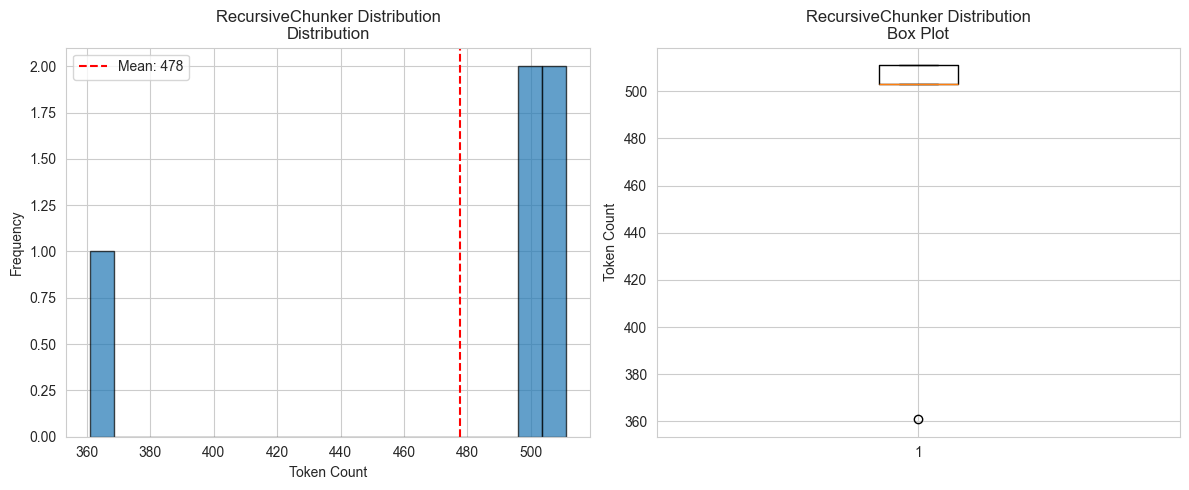


Statistics:
  Mean: 477.8
  Median: 503.0
  Std Dev: 58.5
  Min: 361
  Max: 511


In [11]:
from chonkie import RecursiveChunker

# Create RecursiveChunker
recursive_chunker = RecursiveChunker(
    tokenizer=tokenizer,
    chunk_size=512
)

# Chunk technical documentation (has good structure)
recursive_chunks = recursive_chunker(technical_doc_text)  # Can also use __call__

display_chunks(recursive_chunks)
visualize_chunk_sizes(recursive_chunks, "RecursiveChunker Distribution")

In [12]:
# Demonstrate hierarchy preservation
print("First chunk shows hierarchy preservation:")
print(recursive_chunks[0].text)

First chunk shows hierarchy preservation:
# Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite of chunking algorithms designed for different document types and use cases.

## Installation

### Basic Installation

To install Chonkie with default chunkers:

```bash
pip install chonkie
```

### Installation Tiers

Chonkie offers three installation tiers to match your needs:

**Default Tier:**
Includes TokenChunker, SentenceChunker, RecursiveChunker, and TableChunker. Perfect for most use cases.

```bash
pip install chonkie
```

**Semantic Tier:**
Adds embedding-based chunkers (SemanticChunker, LateChunker, NeuralChunker):

```bash
pip install chonkie[semantic]
```

**All Features:**
Install everything, including code chunking and LLM-powered chunking:

```bash
pip install chonkie[all]
```

## Quick Start

### Basic Usage

All Chonkie chunkers fo

In [13]:
from chonkie import TableChunker

# Create TableChunker
table_chunker = TableChunker(
    tokenizer=tokenizer,
    chunk_size=512
)

# Chunk table data
table_chunks = table_chunker.chunk(table_text)

print(f"Table split into {len(table_chunks)} chunks")
print("\nFirst chunk (with headers):")
print(table_chunks[1].text)

Table split into 5 chunks

First chunk (with headers):
# Chonkie Chunkers Comparison Table

## Performance Metrics Across Different Chunkers

| Chunker Name | Use Case | Processing Speed (chunks/sec) | Semantic Quality (0-100) | Memory Usage (MB) | Token Consistency | Best For | Computational Cost |
| Thread Safe | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Limited |
| Batch Processing | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Limited |
| Configurable Threshold | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes |
| Custom Separators | No | No | Yes | No | No | Yes | No | No | No |
| AST Parsing | No | No | No | No | No | Yes | No | No | No |
| LLM Powered | No | No | No | No | No | No | No | No | Yes |

## Resource Requirements

| Chunker | CPU Usage (%) | GPU Required | RAM (GB) | API Key Required | Cost Per 1M Chunks | Latency (ms/chunk) |
|---|---|---|---|---|---|---|
| TokenChunker | 5-10 | No | 0.5 | No | $0 | 0.08 |
| SentenceChunker | 8-12 | No | 0.6 | No | $0 | 

In [15]:
from chonkie import CodeChunker

# Create CodeChunker
code_chunker = CodeChunker(
    language="python",
    chunk_size=2048,
    include_nodes=True  # Include AST node information
)

# Chunk Python code
code_chunks = code_chunker.chunk(code_text)

print(f"Code split into {len(code_chunks)} chunks")
print("\n--- First Code Chunk ---")
print(code_chunks[0].text[:500])

# Show function boundaries
if hasattr(code_chunks[0], 'node_type'):
    print(f"\nNode type: {code_chunks[0].node_type}")

Code split into 8 chunks

--- First Code Chunk ---
"""
Chonkie RAG System Implementation
A production-ready implementation of a Retrieval-Augmented Generation system using Chonkie chunkers.
"""

import os
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass
from enum import Enum
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import logging


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogg


In [ ]:
# from chonkie import OpenAIEmbeddings
# load_dotenv()

# oembeddings = OpenAIEmbeddings()

# from chonkie import GeminiEmbeddings

# Initialize Gemini embeddings

embeddings = GeminiEmbeddings(
model="gemini-embedding-001",
api_key=GOOGLE_API_KEY,
task_type="SEMANTIC_SIMILARITY"
)
    
from chonkie import SemanticChunker

# Create SemanticChunker with Gemini embeddings
semantic_chunker = SemanticChunker(
    embedding_model=embeddings,  # Using our embeddings
    threshold=0.8,  # Automatically determine threshold
    chunk_size=512,
    min_sentences=3
)

# Chunk research paper (has multiple topics)
semantic_chunks = semantic_chunker.chunk(research_paper_text)

display_chunks(semantic_chunks)
visualize_chunk_sizes(semantic_chunks, "SemanticChunker Distribution")

In [ ]:
# Show semantic similarity scores (if available)
for i, chunk in enumerate(semantic_chunks[:5]):
    print(f"\nChunk {i}: {len(chunk.text)} chars")
    if hasattr(chunk, 'similarity_score'):
        print(f"Similarity score: {chunk.similarity_score:.3f}")
    print(f"Preview: {chunk.text[:150]}...")
    
    
    # Compare automatic vs manual threshold
semantic_chunker_manual = SemanticChunker(
    embedding_model=embeddings,
    threshold=0.5,  # Manual threshold
    chunk_size=512,
    min_sentences=1
)

manual_chunks = semantic_chunker_manual.chunk(research_paper_text[:5000])

print(f"Auto threshold: {len(semantic_chunks)} chunks")
print(f"Manual threshold (0.5): {len(manual_chunks)} chunks")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]


Total chunks: 5

Chunk 1:
Text: # Chonkie API Documentation

## Overview

Chonkie is a lightweight, high-performance library for chunking text in Retrieval-Augmented Generation (RAG) applications. It provides a comprehensive suite o...
Token count: 488
--------------------------------------------------------------------------------

Chunk 2:
Text: 
**Methods:**
- `chunk(text: str) -> List[Chunk]`: Chunk a single text
- `chunk_batch(texts: List[str]) -> List[List[Chunk]]`: Chunk multiple texts
- `__call__(text: str) -> List[Chunk]`: Direct calli...
Token count: 488
--------------------------------------------------------------------------------

Chunk 3:
Text: - `separators` (List[str]): Delimiters in priority order (default: ["\n\n", "\n", ". ", " "])

**Use Cases:**
- Markdown documents
- Structured text with clear hierarchy
- Documents with multiple sect...
Token count: 505
--------------------------------------------------------------------------------

... and 2 more chunks


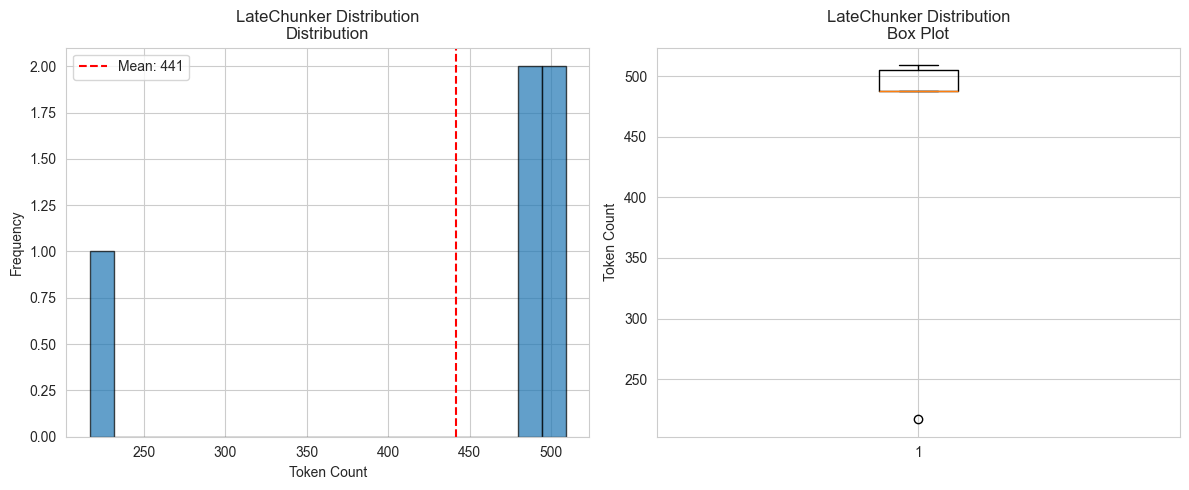


Statistics:
  Mean: 441.4
  Median: 488.0
  Std Dev: 112.5
  Min: 217
  Max: 509


In [19]:
from chonkie import LateChunker

# Create LateChunker
late_chunker = LateChunker(
    embedding_model="nomic-ai/modernbert-embed-base",
    chunk_size=512
)

# Chunk technical documentation
late_chunks = late_chunker.chunk(technical_doc_text)

display_chunks(late_chunks)
visualize_chunk_sizes(late_chunks, "LateChunker Distribution")